In [7]:
!ls ./data/*

./data/item_categories.csv   ./data/sample_submission.csv
./data/items.csv             ./data/shops.csv
./data/sales_train.csv       ./data/test.csv


In [8]:
import numpy as np
import pandas as pd
import random as rd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
sales = pd.read_csv( 'data/sales_train.csv')

# Warnings
import warnings
warnings.filterwarnings('ignore')

item_cat = pd.read_csv( 'data/item_categories.csv')
item = pd.read_csv( 'data/items.csv')
sub = pd.read_csv( 'data/sample_submission.csv')
shops = pd.read_csv( 'data/shops.csv')
test = pd.read_csv( 'data/test.csv')

In [27]:
sales.date = sales.date.apply( lambda x: datetime.datetime.strptime( x, '%d.%m.%Y' ) )

In [29]:
print( sales.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [36]:
group_by_cols = [ "date_block_num", "shop_id", "item_id" ]
info_cols = ["date", "item_price", "item_cnt_day"]
agg_rules = {"date" : ["min", "max"], "item_price" : "mean", "item_cnt_day" : "sum"}

monthly_sales = sales.groupby( group_by_cols )[info_cols].agg(agg_rules)

In [41]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

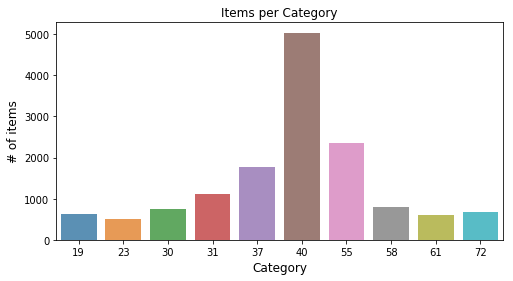

In [83]:
x = item.groupby('item_category_id').count()
x = x.sort_values( by=['item_id'], ascending=False )
x = x.iloc[0:10].reset_index()

# Plot
plt.figure( figsize=(8,4) )
ax = sns.barplot( x.item_category_id, x.item_id, alpha=0.8 )
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [88]:
ts = sales.groupby( "date_block_num" )["item_cnt_day"].sum()

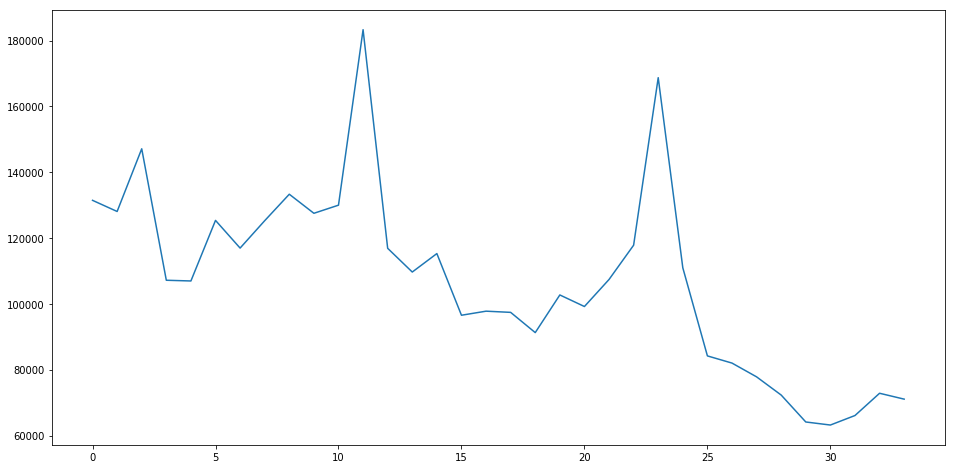

In [90]:
plt.figure(figsize=(16,8) )
plt.plot(ts)

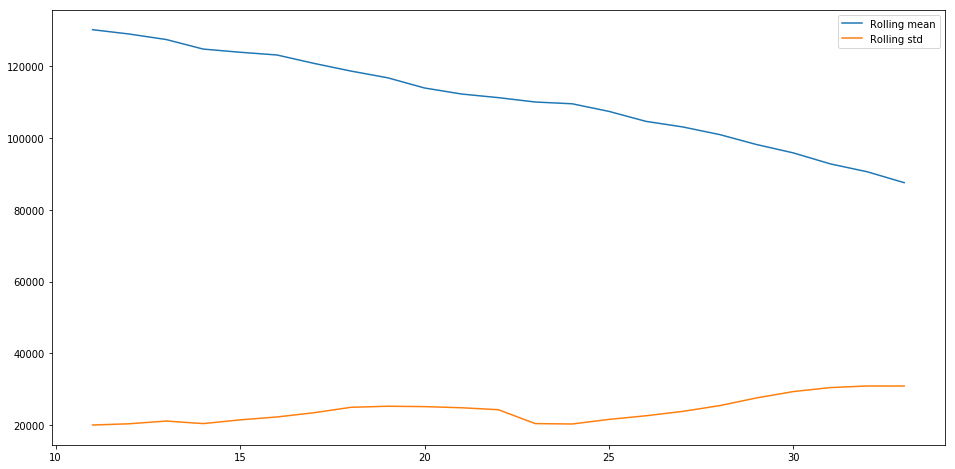

In [91]:
plt.figure(figsize=(16,8) )
plt.plot( ts.rolling(window=12, center=False).mean(), label="Rolling mean" )
plt.plot( ts.rolling(window=12, center=False).std(), label="Rolling std" )
plt.legend()

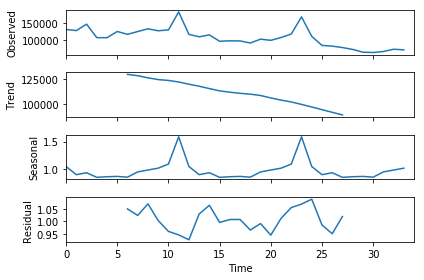

In [96]:
import statsmodels as sm
res = sm.tsa.seasonal.seasonal_decompose( ts.values, freq=12, model="multiplicative" )
fig = res.plot()

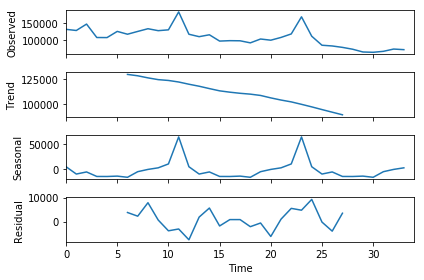

In [97]:
import statsmodels as sm
res = sm.tsa.seasonal.seasonal_decompose( ts.values, freq=12, model="additive" )
fig = res.plot()

In [102]:
def stationarity_test(timeseries):
    
    # Perform Dickey-Fuller test
    print( 'Results of Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series( dftest[0:4], index = [ 'Test Statistic', 'p-value', "# of lags used", 'Number of Observations used'] )
    
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    
    print(dfoutput)
        

In [103]:
stationarity_test(ts)

Results of Dickey-Fuller test:
Test Statistic                 -2.395704
p-value                         0.142953
# of lags used                  0.000000
Number of Observations used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [112]:
from pandas import Series as Series

def difference( dataset, interval=1 ):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
        
    return( Series(diff) )

def inverse_difference( last_ob, value ):
    return( value + last_ob )


        

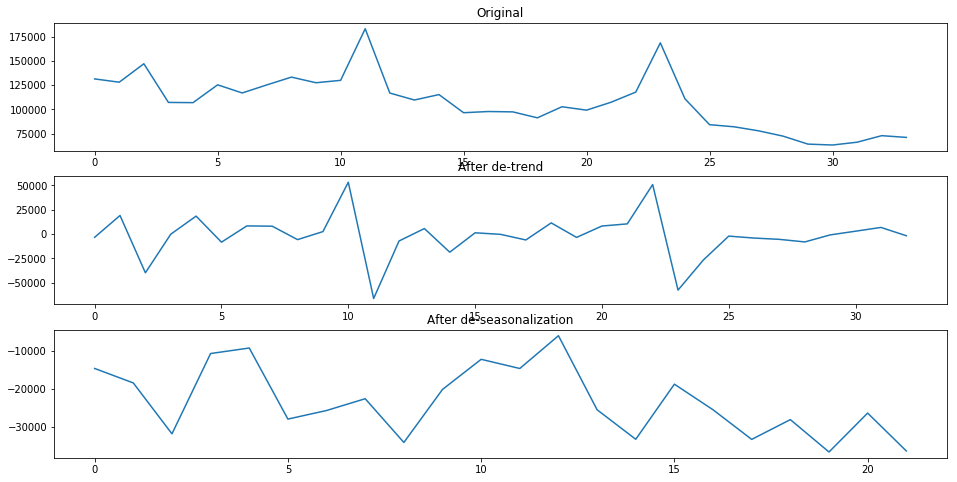

In [114]:
plt.figure(figsize=(16,8))
plt.subplot(311)
plt.title( 'Original' )
plt.plot(ts)

plt.subplot(312)
plt.title( 'After de-trend' )
new_ts = difference(ts)
plt.plot(new_ts)

plt.subplot(313)
plt.title( 'After de-seasonalization' )
new_ts = difference(ts, interval=12)
plt.plot(new_ts)

In [116]:
stationarity_test(new_ts)

Results of Dickey-Fuller test:
Test Statistic                 -3.270101
p-value                         0.016269
# of lags used                  0.000000
Number of Observations used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [128]:
from statsmodels.graphics.gofplots import qqplot

def tsplot(y, lags=None, figsize=(10,8), style="bmh", title='' ):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2 )
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        ts_ax = plt.subplot2grid(layout, (0,0))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf( y, lags=lags, ax=acf_ax, alpha=0.5 )
        smt.graphics.plot_pacf( y, lags=lags, ax=pacf_ax, alpha=0.5 )
        qqplot( y, line='s', ax=qq_ax )
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=( y.mean(), y.std() ), plot=pp_ax)
        
        plt.tight_layout()
        
    return

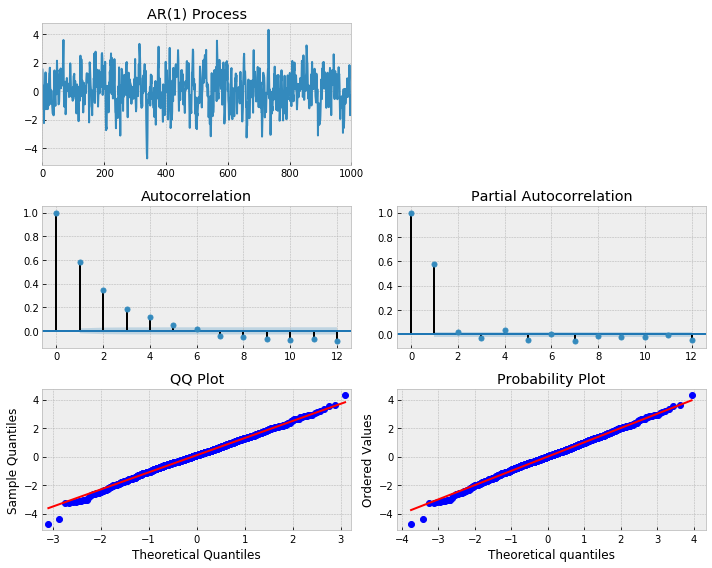

In [132]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)


for t in range(n_samples):
    x[t] = a * x[t-1] + w[t]
    
limit=12

_ = tsplot(x, lags=limit, title="AR(1) Process")

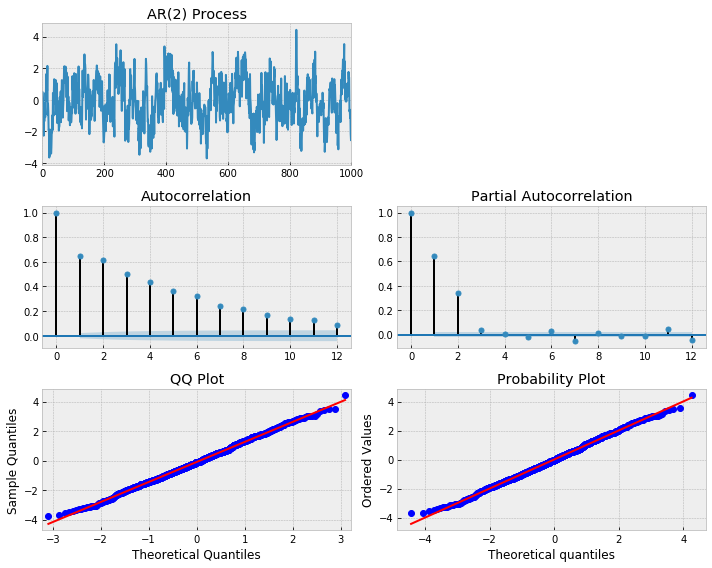

In [143]:
n = int(1000)
alphas = np.array( [0.444, 0.333 ] )
betas = np.array( [0.])

ar = np.r_[ 1, -alphas]
ma = np.r_[1, betas ]

ar2 = smt.arma_generate_sample( ar=ar, ma=ma, nsample=n )

limit=12
_ = tsplot(ar2, lags=limit, title="AR(2) Process")

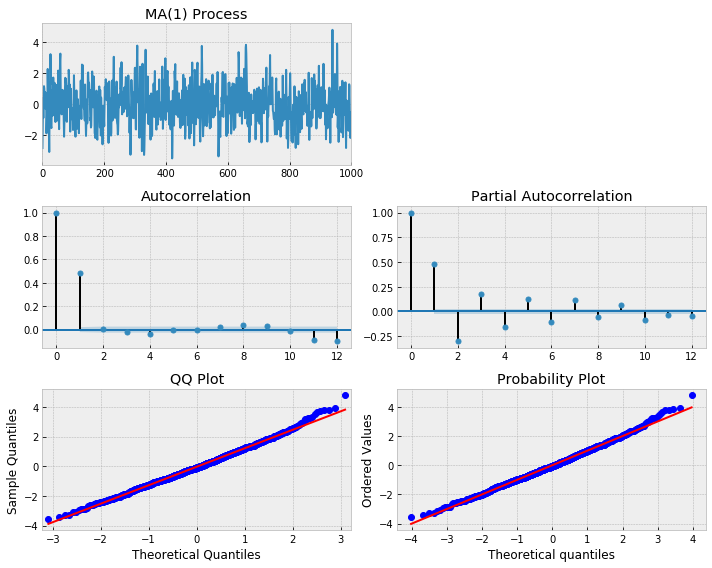

In [147]:
n = int(1000)
alphas = np.array( [0.] )
betas = np.array( [0.8])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas ]

ma1 = smt.arma_generate_sample( ar=ar, ma=ma, nsample=n )

limit=12
_ = tsplot(ma1, lags=limit, title="MA(1) Process")

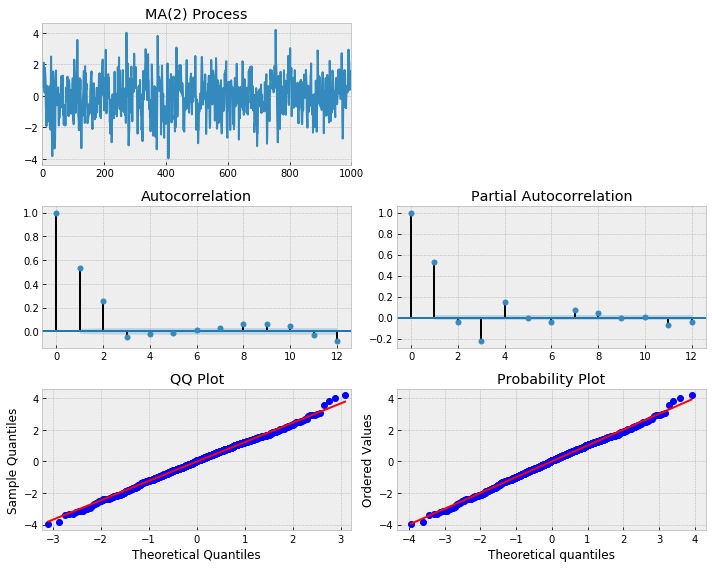

In [148]:
n = int(1000)
alphas = np.array( [0.] )
betas = np.array( [0.6, 0.4])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas ]

ma2 = smt.arma_generate_sample( ar=ar, ma=ma, nsample=n )

limit=12
_ = tsplot(ma2, lags=limit, title="MA(2) Process")


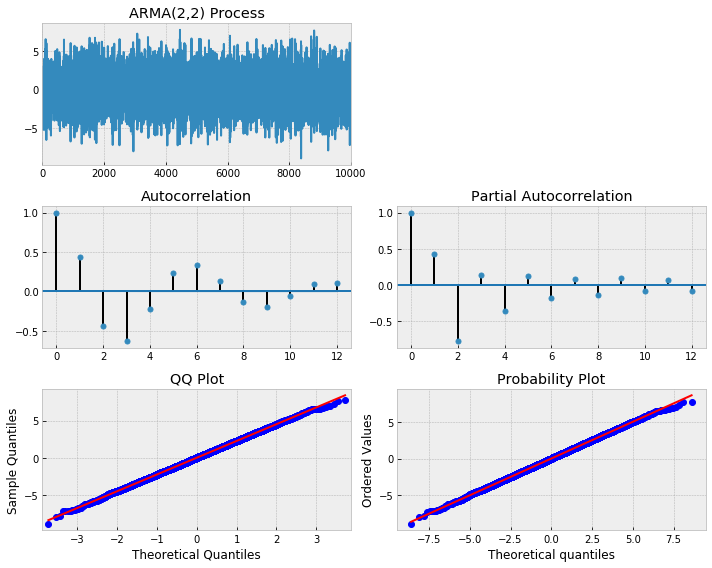

In [165]:
n = int(10000)
alphas = np.array( [0.8, -0.65] )
betas = np.array( [0.5, -0.7])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas ]

arma22 = smt.arma_generate_sample( ar=ar, ma=ma, nsample=n )

limit=12
_ = tsplot(arma22, lags=limit, title="ARMA(2,2) Process")

In [167]:

best_aic = np.inf
best_order = None
best_mdl = None

input_ts = new_ts.values

rng = range(5)
for i in rng:
    for j in rng:
        
        try:
            tmp_mdl = smt.ARMA( input_ts, order=(i,j)).fit(method="mle", trend="nc")
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i,j)
                best_mdl = tmp_mdl
        except:
            continue
            
print( 'aic: {:6.5f} | order: {}'.format(best_aic, best_order) )

aic: 472.99703 | order: (1, 1)


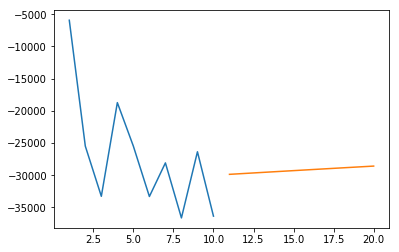

In [186]:
# Predict using the best model 
pp = best_mdl.predict(start=len(input_ts), end=len(input_ts)+9)
fig = plt.plot(np.linspace(1,10,10), input_ts[-10:])
plt.plot(np.linspace(11,20,10), pp)

In [189]:
ts = sales.groupby( ["date_block_num"])["item_cnt_day"].sum()
ts.index = pd.date_range(start = "2013-01-01", end="2015-10-01", freq = "MS")
ts = ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [195]:
from fbprophet import Prophet

ts.columns = ['ds', 'y']

model = Prophet( yearly_seasonality=True )
model.fit(ts)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [198]:
future = model.make_future_dataframe(periods=5, freq="MS")
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957161,80067.218607,86279.449582
35,2015-12-01,125513.062787,122484.157093,128576.162564
36,2016-01-01,75625.688443,72301.032437,78551.929312
37,2016-02-01,40109.144323,36788.973450,43182.471715
38,2016-03-01,76664.084516,73555.632537,79647.105405


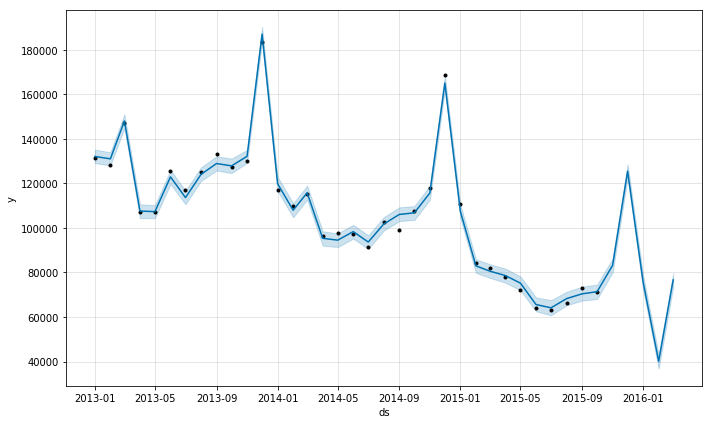

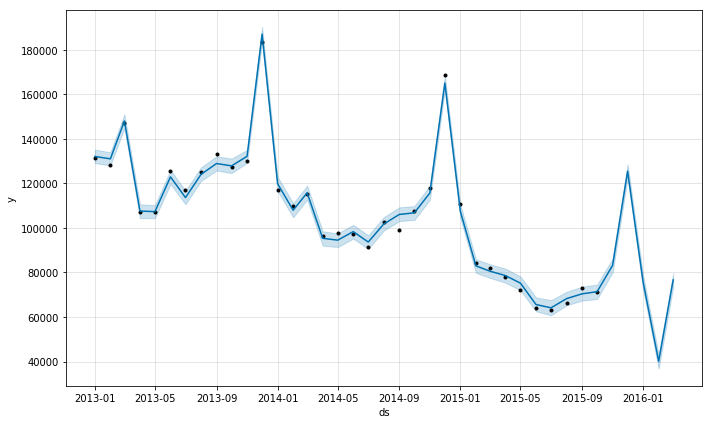

In [199]:
model.plot(forecast)

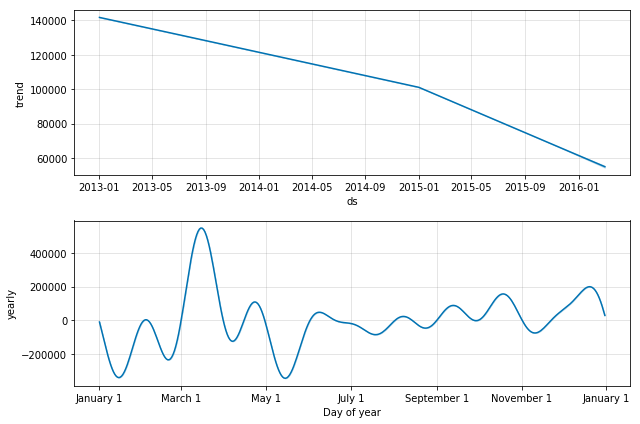

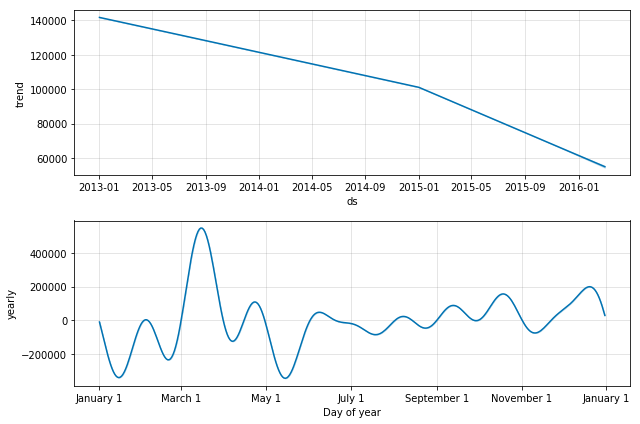

In [200]:
model.plot_components(forecast)

In [264]:
from datetime import datetime, time
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
items = pd.read_csv('data/items.csv')
item_cats = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

In [265]:
# Restrict the train set to just shops and items that are also in the test set
test_shops = test.shop_id.unique()
train = train[ train.shop_id.isin(test_shops) ]
test_items = test.item_id.unique()
train = train[ train.item_id.isin(test_items) ]

In [221]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)


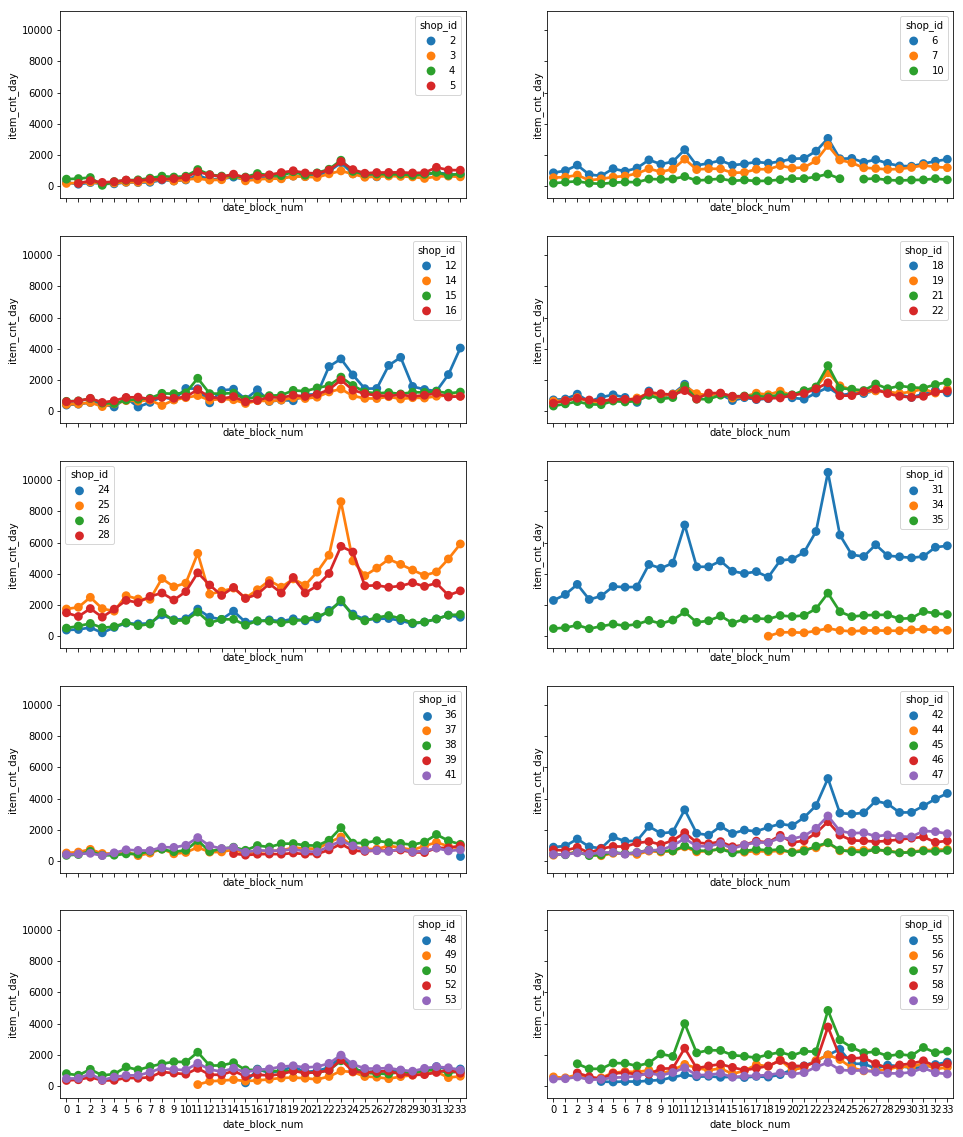

In [253]:
grouped = pd.DataFrame( train.groupby( ['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index() )
fig, axes = plt.subplots( nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20) )
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph )

count = 0
for i in range(5):
    for j in range(2):
        # Get the data for the i-j-th plot
        cond_1 = count * id_per_graph <= grouped.shop_id
        cond_2 = grouped.shop_id < (count+1) * id_per_graph
        dt = grouped[ np.logical_and( cond_1, cond_2 ) ]
        
        sns.pointplot( x="date_block_num", y="item_cnt_day", hue="shop_id", data=dt, ax=axes[i][j] )
        
        count += 1

In [266]:
# Add the item_category_id to the training set
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [271]:
train['date_fmt'] = train.date.apply( lambda x: datetime.strptime( x, '%d.%m.%Y') )

In [274]:
train['month'] = [ x.strftime( '%m' ) for x in train.date_fmt ]
train['year'] = [ x.strftime( '%Y' ) for x in train.date_fmt ]

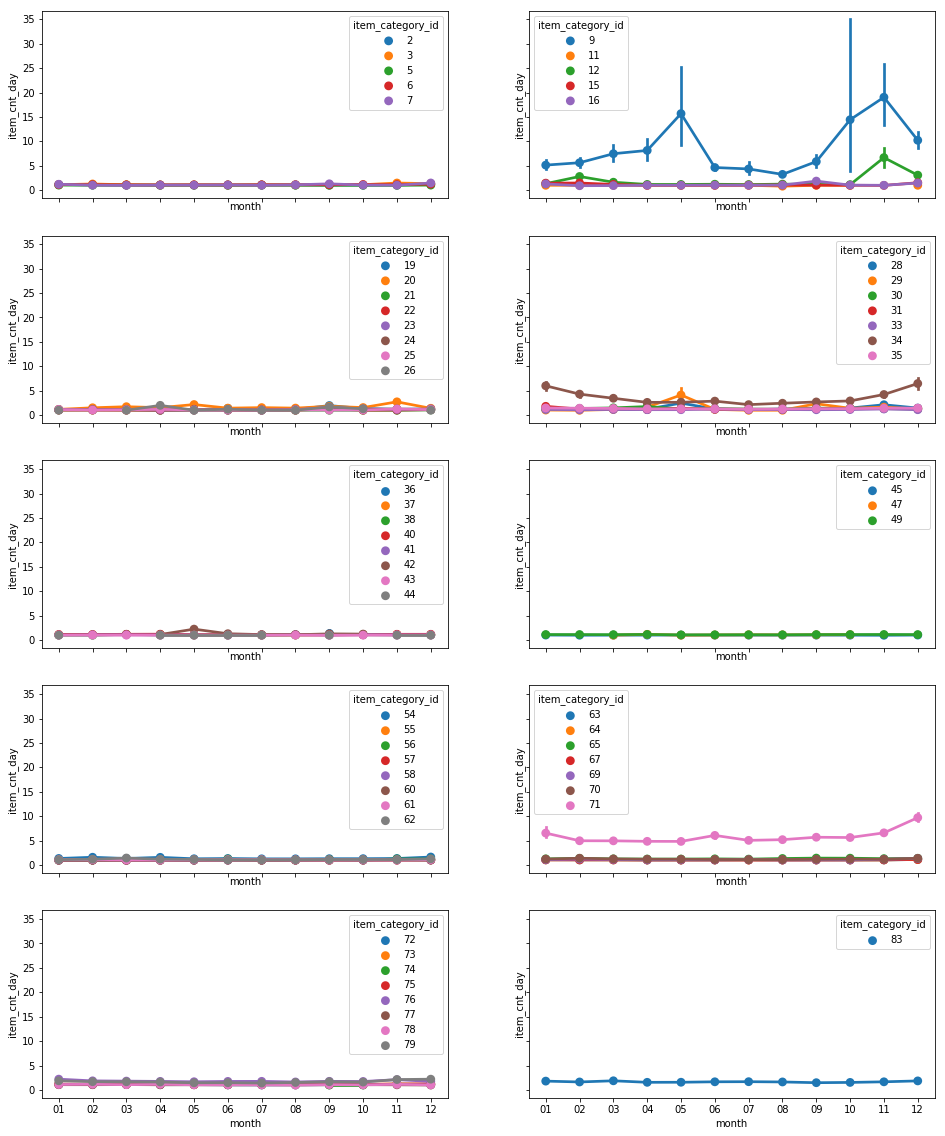

In [281]:
fig, axes = plt.subplots( nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20) )
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph )

count = 0
for i in range(5):
    for j in range(2):
        # Get the data for the i-j-th plot
        cond_1 = count * id_per_graph <= train.item_category_id
        cond_2 = train.item_category_id < (count+1) * id_per_graph
        dt = train[ np.logical_and( cond_1, cond_2 ) ]
        
        sns.pointplot( x="month", y="item_cnt_day", hue="item_category_id", data=dt, ax=axes[i][j] )
        
        count += 1